# 3. Sampling interval selection

The aim of this notebook is to find the most appropriate sampling interval for which to predict the number of cars. We will use the best performing model of the previous section to determine this

## Setup

In [2]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

from utils import *
%load_ext autoreload
%autoreload 2

#### Load data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/405.txt' #../data/405.txt'

cols_map = {
    "DTS": "crossTime",
    #"LANE": "lane",
    #"DIR": "direction",
    "SPEED": "speed",
    # "AX": "nAxles",
    "GW_TOT": "weight",
    # "TYPE": "type",
}

data = pd.read_csv(DATA_PATH, usecols=cols_map.keys())
data.rename(columns=cols_map, inplace=True)
# Parse crossTime column as datetime object
data.crossTime = pd.to_datetime(data.crossTime+'0000', format='%Y-%m-%d %H:%M:%S.%f')
data.head(2)

,crossTime,speed,weight
0,2011-04-01 00:41:31.400,106,15980
1,2011-04-01 00:42:10.500,116,3630


## Feature engineering

We take the raw data and transform it using the pipeline defined in the previous notebook. We do so for our 3 sampling intervals we wish to test.

In [5]:
def pipeline(features, sampling_interval):
    
    # Index by crossing time
    feature_cols = [col for col in data.columns if col != 'crossTime']
    features = data[feature_cols]
    features.index = data.crossTime

    # Truncate data to ignore COVID pandemic 
    start_of_covid = "2019-10-21"
    features = features.truncate(after=start_of_covid)
    
    # Downsample and add vehicle counts
    resampled = features.resample(sampling_interval)
    features = resampled.sum()
    features['n_vehicles'] = resampled.size()
    
    legal_driving_start = 5  #  5 AM
    legal_driving_end = 22   # 10 PM
    legal_driving_duration = legal_driving_end - legal_driving_start
    sunday = 6

    # HGV Vehicle restrictions
    dayofweek = pd.Series(features.index.dayofweek, index=features.index)
    hours = pd.Series(features.index.hour, index=features.index)
    shifted_hours = hours - legal_driving_start

    features['is_legal'] = (((0 <= shifted_hours) & (shifted_hours < legal_driving_duration))).astype(int)
    
    # Time periodicity features
    minute_s = 60
    hour_s = minute_s * 60
    day_s = 24 * hour_s # 24h x 60m x 60s
    week_s = 7 * day_s
    year_s = 365.2425 * day_s 
    
    features = add_time_period_cols(features, day_s, 'day')
    features = add_time_period_cols(features, week_s, 'week')
    features = add_time_period_cols(features, year_s, 'year')
    
    # Splitting and normalizing
    return split_norm_data(features, return_mean_std=True)

In [6]:
# List of tuples (interval, frequency of interval in 1 hour)
sampling_intervals = [('1h', 1), ('30min', 2), ('10min', 6)]

# Targets to predict
labels = ['n_vehicles', 'speed', 'weight']

## Performance evalutaion

We create the windows for each interval, then fit our model to the training data. We then evaluate the model and log the performance.

In [9]:
val_performance = {}

In [ ]:
models = []

for interval, frequency in sampling_intervals:
    print(f'Interval: {interval}')
    
    # Create nice datasets
    train, val, test, train_mean, train_std = pipeline(data, interval)
    
    # Create window
    week_steps = 7 * 24 * frequency
    year_steps = 52 * week_steps
    shift_steps = year_steps
    
    week_window = make_window(train, val, test, train_mean, train_std,
                              input_w=week_steps, label_w=week_steps,
                              shift=shift_steps, label_cols=labels)
    
    # Use best model from before
    rnn = lstm_model(len(labels), week_steps)
    history = compile_and_fit(rnn, week_window)
    
    IPython.display.clear_output()
    
    # Evaluate performance
    val_performance[interval] = rnn.evaluate(week_window.val)

## Performance

We see that our largest interval performs the best. We will select 1h as our sampling interval since this is the largest interval still comfortable for the discretization phase

In [20]:
for interval, [mse, mae] in val_performance.items():
    print(f"{interval:7s}: MSE={mse:.3f} MAE={mae:.3f}")

1h     : MSE=0.261 MAE=0.296
30min  : MSE=0.268 MAE=0.304
10min  : MSE=0.317 MAE=0.348


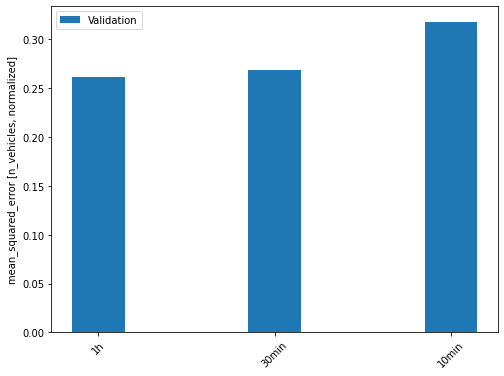

In [21]:
x = np.arange(len(val_performance))
width = 0.3
val_mae = [v[0] for v in val_performance.values()]

plt.ylabel('mean_squared_error [n_vehicles, normalized]')
plt.bar(x, val_mae, width, label='Validation')
plt.xticks(ticks=x, labels=val_performance.keys(),
           rotation=45)
_ = plt.legend()

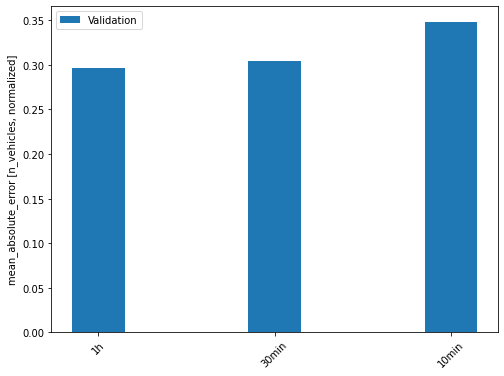

In [24]:
x = np.arange(len(val_performance))
width = 0.3
val_mae = [v[1] for v in val_performance.values()]

plt.ylabel('mean_absolute_error [n_vehicles, normalized]')
plt.bar(x, val_mae, width, label='Validation')
plt.xticks(ticks=x, labels=val_performance.keys(),
           rotation=45)
_ = plt.legend()